In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy

Using TensorFlow backend.


## Approach 3

Previously we have used LSTM on daily sales data. But we did not make our time series stationary.

In this approach we will discuss how walk forward validation method affects the accuracy.

**Steps for Walk Forward Validation:**

   1. Minimum number of samples is chosen as window which used to train a model.
   2. The model makes a prediction for the next time step.
   3. The prediction is evaluated against the actual value.
   4. The window is expanded to include the known value and the process is repeated (go to step 1.)
   5. Because this method involves moving along the time series one-time step at a time, it is called Walk Forward Validation.
    
For detail information please refer: 
https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

This method is inspired by following blog:
https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

#### Using parse_dates=[0],squeeze=True we will load a csv as time series file

In [2]:
# load dataset
daily_df = read_csv('daily_data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [3]:
daily_df.head(5)

date
2016-09-04    136.23
2016-09-05     75.06
2016-09-06      0.00
2016-09-07      0.00
2016-09-08      0.00
Name: Total Price, dtype: float64

#### Next we will transform the data to be stationary.
We can see that our data has increasing trend, i.e, sales increses with time.<br>Stationarity is important because, without it, a model describing the data will vary in accuracy at different time points.

Hence, stationarity is required for sample statistics such as means, variances, and correlations to accurately describe the data at all time points of interest.
<br>To make the series stationary we are going to remove trend and then predict sales. After predictions, we will add trend to forecasted values.

We can remove trend by differencing the data.<br>That is the observation from the previous time step (t-1) is subtracted from the current observation (t).The resultant series will be a difference series, or the changes to the observations 
from one time step to the next.

Referance: https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary

In [13]:
#Get differance
def calculate_difference(data, interval=1):
    differance = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        differance.append(value)
    return Series(differance)

In [14]:
# transform data to be stationary
data = daily_df.values
diff_values = calculate_difference(data, 1)

#### If we observe 1st value -61.17 = 75.06-136.23

In [15]:
diff_values.head()

0   -61.17
1   -75.06
2     0.00
3     0.00
4     0.00
dtype: float64

**Now convert differentiated series in supervised learning problem. For that we will use observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.**

In [16]:
#Convert time series into X and Y by adding columns
def timeseries_to_supervised(data, look_back):
    df = DataFrame(data)
    for i in range(1, look_back+ 1):
        #Shift columns
        columns = [df.shift(i)]
        #Append columns
        columns.append(df)
        df = concat(columns, axis=1)
        #Fill added columns by 0
        df.fillna(0, inplace=True)
        return df

In [17]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, look_back=1)
supervised_values = supervised.values

In [18]:
supervised_values

array([[  0.  , -61.17],
       [-61.17, -75.06],
       [-75.06,   0.  ],
       ...,
       [  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [  0.  , 166.46]])

**Split the dataset for training and testing**

In [19]:
#Split dataset
train, test = supervised_values[0:-105], supervised_values[-105:]

In [20]:
train

array([[    0.  ,   -61.17],
       [  -61.17,   -75.06],
       [  -75.06,     0.  ],
       ...,
       [  463.05, -8110.05],
       [-8110.05, -5233.61],
       [-5233.61,  6579.85]])

**Scale, transform and reshape the data**

In [21]:
def scale(train, test):
    # fit scaler
    scaler = StandardScaler()
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [22]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [23]:
train_scaled

array([[-0.00394423, -0.01163049],
       [-0.01050424, -0.0131195 ],
       [-0.01199383, -0.00507306],
       ...,
       [ 0.04571431, -0.87447096],
       [-0.8736845 , -0.5661164 ],
       [-0.56520851,  0.7002873 ]])

#### Fit an LSTM network to training data

Here we will use stateful parameter of LSTM model:

**stateful:** *Boolean (default False).*<br> *If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.*

It will consider each row as a batch, store state of that row and will use it as input to next batch

In [25]:
#Build and fit model useing stateful parameter
def fit_lstm(train, batch_size, epochs, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    #Reshape data
    X = X.reshape(X.shape[0], 1, X.shape[1])
    #Build model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #Fit model
    for i in range(epochs):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [26]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 200, 4)

In [27]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


array([[-1.10468090e+00],
       [-8.69640052e-01],
       [-6.29709363e-01],
       [-4.17768955e-01],
       [-2.47022510e-01],
       [-1.19189501e-01],
       [-3.18878889e-02],
       [ 2.58170366e-02],
       [ 6.41278028e-02],
       [ 9.03376341e-02],
       [ 1.08886838e-01],
       [ 1.19734883e-01],
       [ 1.31964684e-01],
       [ 1.41969323e-01],
       [ 1.46103621e-01],
       [ 1.50919676e-01],
       [ 1.54253364e-01],
       [ 1.57014966e-01],
       [ 1.59165502e-01],
       [ 1.60879135e-01],
       [ 1.62234426e-01],
       [ 1.63311124e-01],
       [ 1.64167285e-01],
       [ 1.64848685e-01],
       [ 1.65392637e-01],
       [ 1.65827036e-01],
       [ 1.66175485e-01],
       [ 1.66455030e-01],
       [ 1.65053725e-01],
       [ 1.57859325e-01],
       [-2.64894962e-03],
       [ 3.28427553e-02],
       [ 1.54273272e-01],
       [ 1.53102756e-01],
       [ 1.51860595e-01],
       [ 2.23428965e-01],
       [ 2.41220355e-01],
       [ 2.44717002e-01],
       [ 2.5

In [28]:
train_reshaped.shape

(624, 1, 1)

**Now we will use lstm_model which is trained on differanced data and it's state is built up by forecasting training data**

In [29]:
#Forecast test data
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#### Inverse scaling for a forecasted differance

In [30]:
#De-normalize data
def invert_scale(scaler, X, diff_val):
    new_row = [x for x in X] + [diff_val]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

#### Inverse differenced trained data by adding forecasted differance to trained data

In [31]:
#Add forecasted difference to trained data
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

#### Now our actual value is train data+forecasted differance and actual value is test data

In [32]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    
    # invert differencing
    yhat = inverse_difference(daily_df, yhat, len(test_scaled)+1-i)
    
    # store forecast
    predictions.append(yhat)
    expected = daily_df[len(train) + i + 1]
    print('day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

day=1, Predicted=32405.727950, Expected=32070.680000
day=2, Predicted=32220.152922, Expected=20262.290000
day=3, Predicted=24044.895057, Expected=22274.670000
day=4, Predicted=26879.507275, Expected=18137.370000
day=5, Predicted=22395.580905, Expected=16914.090000
day=6, Predicted=21196.281752, Expected=14693.680000
day=7, Predicted=18134.265812, Expected=30304.950000
day=8, Predicted=30226.241805, Expected=29430.630000
day=9, Predicted=28069.008244, Expected=22529.080000
day=10, Predicted=24602.440644, Expected=28156.520000
day=11, Predicted=28825.546047, Expected=37282.670000
day=12, Predicted=31889.717296, Expected=28939.990000
day=13, Predicted=27886.858785, Expected=32869.900000
day=14, Predicted=32243.407668, Expected=34326.400000
day=15, Predicted=31134.922350, Expected=36101.720000
day=16, Predicted=33515.075658, Expected=32176.980000
day=17, Predicted=33264.266925, Expected=42676.380000
day=18, Predicted=39984.176565, Expected=31797.200000
day=19, Predicted=32081.034607, Expec

#### Calculate RMSE and plot result

Test RMSE: 7948.94


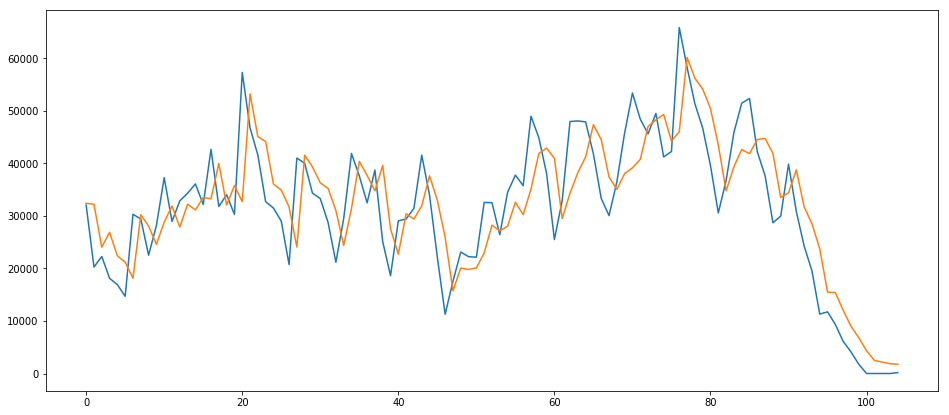

In [34]:
#Calculate RMSE
rmse = sqrt(mean_squared_error(data[-105:], predictions))
print('Test RMSE: %.2f' % rmse)
plt.figure(figsize=(16, 7))
plt.plot(data[-105:])
plt.plot(predictions)
plt.show()

### Conclusion: 
**This model gives us least RMSE and follows trend and seasonality.
Still there is considerable difference in level(Actual and predicted values), which can be improved by adjusting hyperparameters**